In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
from keras.datasets import mnist

x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

---

In [8]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
def fn_mnist_cnn_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 100000. - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [49]:
def fn_mnist_cnn_margin(features, labels, mode):
    """Model function for CNN."""
    
    C = 1
    lamda = 1e-1
    EPS = 1e-6
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., C - y_label + y_max))
    
    # Add penalty term
    grad = tf.gradients(y_label, input_layer, name='grad')
    grad_norm = tf.norm(tf.reshape(grad, shape=[-1, 28 * 28]), 
                        ord='euclidean', axis=-1)
    penalty = tf.reduce_sum(tf.square(grad_norm) 
                            / (y_label + EPS), name='penalty')
    loss += lamda * penalty
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [50]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=fn_mnist_cnn_margin, model_dir='./tmp/mnist_cnn_margin_C1_L1e-1/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/mnist_cnn_margin_C1_L1e-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe888e1a438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [51]:
#tensors_to_log = {"probabilities": "softmax_tensor"}
#tensors_to_log = {"gather_ind": "gather_ind", "y_l": "y_l"}
tensors_to_log = {"accuracy": "accuracy",
                  "penalty": "penalty"}
#tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=100)

In [52]:
def get_weights(estimator):
    """
    Extract weights from TF Estimator. Only works with a simple CNN/DNN.
    """

    weights = []
    weight = []
    layer_names = estimator.get_variable_names()
    for layer_name in layer_names:
        if layer_name.endswith("kernel"):
            weight.insert(0, estimator.get_variable_value(layer_name))
            weights.append(weight)
            weight = []
        elif layer_name.endswith("bias"):
            weight.append(estimator.get_variable_value(layer_name))
            
    return weights


def load_weights(model, weights):
    """
    Set weights in Keras model with a list of weights.
    """
    
    i = 0
    for layer in model.layers:
        # Check if layer has trainable weights
        if not layer.trainable_weights:
            continue
        # Set weight
        layer.set_weights(weights[i])
        i += 1
        
    assert i == len(weights), "Number of layers mismatch."

---

In [53]:
weight_path = './tmp/mnist_cnn_margin_C1_L1e-1/model'
n_epochs = 60

max_test_acc = 0
save_i = 0
train_out = {'accuracy': [], 'loss':[]}
test_out = {'accuracy': [], 'loss':[]}
model = build_cnn_mnist()

for i in range(n_epochs):
    
    if i % 2 is 0:
        try:
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                batch_size=128,
                num_epochs=2,
                shuffle=True)       

            mnist_classifier.train(
                input_fn=train_input_fn,
                hooks=[logging_hook])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            train_out['accuracy'].append(eval_results['accuracy'])
            train_out['loss'].append(eval_results['loss'])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_test},
                y=y_test,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            test_acc = eval_results['accuracy']
            test_out['accuracy'].append(test_acc)
            test_out['loss'].append(eval_results['loss'])

            if test_acc > max_test_acc:
                max_test_acc = test_acc
                save_i = i
                weights = get_weights(mnist_classifier)
                load_weights(model, weights)
                model.save_weights(weight_path + '.h5')
                stop_counter = 0
                print('=========== (+) Test acc: {} ============='.format(test_acc))
            else:
                stop_counter += 1
                print('=========== (-) Test acc: {} ============='.format(test_acc))

            if stop_counter == 5:
                break
                
        except:
            print('--------- NaN encountered - epoch {} ---------'.format(i))
            pass

print('================ Finished in {} epochs ================'.format(i))
pickle.dump(train_out, open(weight_path + '_train.p', 'wb'))
pickle.dump(test_out, open(weight_path + '_test.p', 'wb'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt.
INFO:tensorflow:accuracy = 0.0859375, penalty = 7.9743195
INFO:tensorflow:loss = 151.49493, step = 0
INFO:tensorflow:global_step/sec: 74.919
INFO:tensorflow:accuracy = 0.71875, penalty = 15.480253 (1.337 sec)
INFO:tensorflow:loss = 88.72907, step = 100 (1.337 sec)
INFO:tensorflow:global_step/sec: 88.6192
INFO:tensorflow:accuracy = 0.7890625, penalty = 44.893112 (1.128 sec)
INFO:tensorflow:loss = 64.44061, step = 200 (1.129 sec)
INFO:tensorflow:global_step/sec: 89.4691
INFO:tensorflow:accuracy = 0.8515625, penalty = 33.68357 (1.117 sec)
INFO:tensorflow:loss = 53.877205, step = 300 (1.117 sec)
INFO:tensorflow:global_step/sec: 89.5314
INFO:tensorflow:accuracy = 0.8984

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-1877
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1878 into ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt.
INFO:tensorflow:accuracy = 0.8671875, penalty = 65.2757
INFO:tensorflow:loss = 56.668617, step = 1877
INFO:tensorflow:global_step/sec: 77.0401
INFO:tensorflow:accuracy = 0.8203125, penalty = 59.416126 (1.300 sec)
INFO:tensorflow:loss = 73.54375, step = 1977 (1.300 sec)
INFO:tensorflow:global_step/sec: 87.0237
INFO:tensorflow:accuracy = 0.875, penalty = 67.74789 (1.153 sec)
INFO:tensorflow:loss = 43.85523, step = 2077 (1.153 sec)
INFO:tensorflow:global_step/sec: 88.3327
INFO:tensorflow:accuracy = 0.9375, penalty = 64.63394 (1.128 sec)
INFO:tensorflow:loss = 38.195107, step = 2177 (1.129 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 23.430481, step = 4553 (1.133 sec)
INFO:tensorflow:global_step/sec: 87.621
INFO:tensorflow:accuracy = 0.9921875, penalty = 51.390022 (1.139 sec)
INFO:tensorflow:loss = 8.155373, step = 4653 (1.139 sec)
INFO:tensorflow:Saving checkpoints for 4691 into ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt.
INFO:tensorflow:Loss for final step: 17.421352.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:07:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-4691
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:07:05
INFO:tensorflow:Saving dict for global step 4691: accuracy = 0.9791167, global_step = 4691, loss = 10.300045
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-0

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6568 into ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt.
INFO:tensorflow:accuracy = 0.9375, penalty = 41.62936
INFO:tensorflow:loss = 23.043583, step = 6567
INFO:tensorflow:global_step/sec: 76.8276
INFO:tensorflow:accuracy = 0.9609375, penalty = 43.028286 (1.303 sec)
INFO:tensorflow:loss = 18.82765, step = 6667 (1.303 sec)
INFO:tensorflow:global_step/sec: 90.1012
INFO:tensorflow:accuracy = 0.9765625, penalty = 40.54304 (1.112 sec)
INFO:tensorflow:loss = 13.924131, step = 6767 (1.112 sec)
INFO:tensorflow:global_step/sec: 89.6126
INFO:tensorflow:accuracy = 0.9453125, penalty = 41.90973 (1.115 sec)
INFO:tensorflow:loss = 20.36516, step = 6867 (1.115 sec)
INFO:tensorflow:global_step/sec: 88.3218
INFO:tensorflow:accuracy = 0.9921875, penalty = 36.04469 (1.132 sec)
INFO:tensorflow:loss = 9.482895, step = 6967 (1.132 sec)
INFO:tensorflow:global_step/sec: 88.2652
INFO:tensorflow:accuracy = 0.9765625, penalty = 34.9

INFO:tensorflow:Saving checkpoints for 9381 into ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt.
INFO:tensorflow:Loss for final step: 4.5701575.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:08:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-9381
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:08:25
INFO:tensorflow:Saving dict for global step 9381: accuracy = 0.9876, global_step = 9381, loss = 6.6274176
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:08:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-9381
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tenso

INFO:tensorflow:loss = 13.392871, step = 11257
INFO:tensorflow:global_step/sec: 73.3849
INFO:tensorflow:accuracy = 0.9921875, penalty = 28.03804 (1.366 sec)
INFO:tensorflow:loss = 6.49324, step = 11357 (1.366 sec)
INFO:tensorflow:global_step/sec: 91.2074
INFO:tensorflow:accuracy = 0.9765625, penalty = 25.08522 (1.095 sec)
INFO:tensorflow:loss = 10.709721, step = 11457 (1.094 sec)
INFO:tensorflow:global_step/sec: 87.6273
INFO:tensorflow:accuracy = 0.96875, penalty = 28.224298 (1.142 sec)
INFO:tensorflow:loss = 16.376583, step = 11557 (1.143 sec)
INFO:tensorflow:global_step/sec: 89.2042
INFO:tensorflow:accuracy = 0.9609375, penalty = 27.644657 (1.122 sec)
INFO:tensorflow:loss = 16.957817, step = 11657 (1.122 sec)
INFO:tensorflow:global_step/sec: 89.999
INFO:tensorflow:accuracy = 0.9765625, penalty = 26.906355 (1.109 sec)
INFO:tensorflow:loss = 9.025325, step = 11757 (1.109 sec)
INFO:tensorflow:global_step/sec: 88.5738
INFO:tensorflow:accuracy = 0.96875, penalty = 24.05643 (1.131 sec)
INF

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:09:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-14071
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:09:45
INFO:tensorflow:Saving dict for global step 14071: accuracy = 0.96203333, global_step = 14071, loss = 16.70831
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:09:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-14071
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:09:46
INFO:tensorflow:Saving dict for global step 14071: accuracy = 0.9633, global_step = 1

INFO:tensorflow:loss = 11.191395, step = 15211 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.5108
INFO:tensorflow:accuracy = 0.9765625, penalty = 22.79218 (1.080 sec)
INFO:tensorflow:loss = 7.2658625, step = 15311 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.5515
INFO:tensorflow:accuracy = 0.96875, penalty = 26.639542 (1.080 sec)
INFO:tensorflow:loss = 13.486708, step = 15411 (1.080 sec)
INFO:tensorflow:global_step/sec: 90.785
INFO:tensorflow:accuracy = 0.9765625, penalty = 28.010406 (1.103 sec)
INFO:tensorflow:loss = 13.1440735, step = 15511 (1.103 sec)
INFO:tensorflow:global_step/sec: 92.2605
INFO:tensorflow:accuracy = 0.96875, penalty = 20.977234 (1.084 sec)
INFO:tensorflow:loss = 10.112761, step = 15611 (1.083 sec)
INFO:tensorflow:global_step/sec: 93.0151
INFO:tensorflow:accuracy = 0.984375, penalty = 20.188866 (1.075 sec)
INFO:tensorflow:loss = 8.455635, step = 15711 (1.075 sec)
INFO:tensorflow:global_step/sec: 91.1577
INFO:tensorflow:accuracy = 0.984375, penalty = 21.383066 

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:11:06
INFO:tensorflow:Saving dict for global step 17825: accuracy = 0.993, global_step = 17825, loss = 3.2124383
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:11:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-17825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:11:06
INFO:tensorflow:Saving dict for global step 17825: accuracy = 0.9884, global_step = 17825, loss = 4.428578
=========== (-) Test acc: 0.9883999824523926 =============
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_

INFO:tensorflow:accuracy = 0.9921875, penalty = 13.910988 (1.108 sec)
INFO:tensorflow:loss = 7.151922, step = 20001 (1.108 sec)
INFO:tensorflow:global_step/sec: 89.7475
INFO:tensorflow:accuracy = 1.0, penalty = 15.248994 (1.116 sec)
INFO:tensorflow:loss = 4.1613197, step = 20101 (1.116 sec)
INFO:tensorflow:global_step/sec: 89.7063
INFO:tensorflow:accuracy = 0.9921875, penalty = 14.46409 (1.114 sec)
INFO:tensorflow:loss = 4.0771375, step = 20201 (1.114 sec)
INFO:tensorflow:global_step/sec: 90.2119
INFO:tensorflow:accuracy = 0.9921875, penalty = 19.22427 (1.108 sec)
INFO:tensorflow:loss = 6.716755, step = 20301 (1.108 sec)
INFO:tensorflow:global_step/sec: 90.4585
INFO:tensorflow:accuracy = 0.96875, penalty = 27.787245 (1.106 sec)
INFO:tensorflow:loss = 14.791761, step = 20401 (1.106 sec)
INFO:tensorflow:global_step/sec: 91.3503
INFO:tensorflow:accuracy = 0.9765625, penalty = 17.938202 (1.093 sec)
INFO:tensorflow:loss = 11.112163, step = 20501 (1.093 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:Saving dict for global step 22515: accuracy = 0.99506664, global_step = 22515, loss = 2.4697475
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:12:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-22515
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:12:25
INFO:tensorflow:Saving dict for global step 22515: accuracy = 0.9907, global_step = 22515, loss = 3.6129935
=========== (+) Test acc: 0.9907000064849854 =============
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-22515
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_

INFO:tensorflow:global_step/sec: 91.122
INFO:tensorflow:accuracy = 0.96875, penalty = 25.054062 (1.097 sec)
INFO:tensorflow:loss = 12.604984, step = 24791 (1.096 sec)
INFO:tensorflow:global_step/sec: 95.3419
INFO:tensorflow:accuracy = 0.9609375, penalty = 24.2547 (1.049 sec)
INFO:tensorflow:loss = 15.806196, step = 24891 (1.049 sec)
INFO:tensorflow:global_step/sec: 94.2891
INFO:tensorflow:accuracy = 0.9765625, penalty = 17.629467 (1.062 sec)
INFO:tensorflow:loss = 10.051379, step = 24991 (1.062 sec)
INFO:tensorflow:global_step/sec: 93.5724
INFO:tensorflow:accuracy = 0.90625, penalty = 52.947403 (1.067 sec)
INFO:tensorflow:loss = 31.84796, step = 25091 (1.067 sec)
INFO:tensorflow:global_step/sec: 94.5319
INFO:tensorflow:accuracy = 0.96875, penalty = 36.874184 (1.062 sec)
INFO:tensorflow:loss = 15.943563, step = 25191 (1.063 sec)
INFO:tensorflow:global_step/sec: 93.8528
INFO:tensorflow:accuracy = 0.9453125, penalty = 34.59124 (1.061 sec)
INFO:tensorflow:loss = 18.061214, step = 25291 (1.

In [ ]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    batch_size=128,
    num_epochs=5,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    hooks=[logging_hook])

In [54]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:43:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-25329
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:43:24
INFO:tensorflow:Saving dict for global step 25329: accuracy = 0.99001664, global_step = 25329, loss = 4.6993933
{'accuracy': 0.99001664, 'loss': 4.6993933, 'global_step': 25329}


In [55]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-13-08:43:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_cnn_margin_C1_L1e-1/model.ckpt-25329
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-13-08:43:25
INFO:tensorflow:Saving dict for global step 25329: accuracy = 0.9861, global_step = 25329, loss = 5.7467895
{'accuracy': 0.9861, 'loss': 5.7467895, 'global_step': 25329}


In [56]:
model = build_cnn_mnist()

In [57]:
weights = get_weights(mnist_classifier)
load_weights(model, weights)
model.evaluate(x_train, y_train_cat)

60000/60000 [==============================] - 5s 91us/step


[0.06371440295924743, 0.9900166666666667]

In [58]:
model.save_weights('./tmp/weights/mnist_cnn_margin_C1_Le-1.h5')

In [59]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 97us/step


[0.06849023367464542, 0.9861]

In [ ]:
# Can we change margin? it doesn't have to be 1

---

In [6]:
model = build_cnn_mnist()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [61]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
#model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')

weight_path = './tmp/mnist_cnn_margin_C1_L1/model'

In [47]:
from lib.OptCarlini import *

In [68]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.4,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         weight_path + '.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=7.587, loss=1.774, obj=9.361
Step: 50, norm=6.586, loss=0.387, obj=6.973
Step: 100, norm=5.647, loss=0.028, obj=5.675
Step: 150, norm=4.993, loss=0.012, obj=5.005
Step: 200, norm=4.715, loss=0.000, obj=4.715
Step: 250, norm=4.574, loss=0.027, obj=4.601
Step: 300, norm=4.496, loss=0.000, obj=4.496
Step: 350, norm=4.448, loss=0.000, obj=4.448
Step: 400, norm=4.403, loss=0.019, obj=4.423
Step: 450, norm=4.396, loss=0.000, obj=4.396
Step: 500, norm=4.375, loss=0.012, obj=4.387
Step: 550, norm=4.369, loss=0.002, obj=4.371
Step: 600, norm=4.359, loss=0.004, obj=4.362
Step: 650, norm=4.351, loss=0.001, obj=4.352
Step: 700, norm=4.346, loss=0.000, obj=4.346
Step: 750, norm=4.337, loss=0.002, obj=4.340
Step: 800, norm=4.341, loss=0.000, obj=4.341
Step: 850, norm=4.329, loss=0.003, obj=4.332
Step: 900, norm=4.323, loss=0.010, obj=4.333
Step: 950, norm=4.328, loss=0.000, obj=4.328
Step: 0, norm=7.823, loss=1.231, obj=9.054
Step: 50, norm=6.108, loss=0.000, obj=6.108
Step: 100, norm=

KeyboardInterrupt: 

In [14]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.470, loss=0.000, obj=13.470
Step: 50, norm=8.580, loss=0.000, obj=8.580
Step: 100, norm=5.743, loss=0.013, obj=5.756
Step: 150, norm=4.380, loss=0.000, obj=4.380
Step: 200, norm=3.581, loss=0.000, obj=3.581
Step: 250, norm=3.116, loss=0.000, obj=3.116
Step: 300, norm=2.789, loss=0.000, obj=2.789
Step: 350, norm=2.601, loss=0.000, obj=2.601
Step: 400, norm=2.458, loss=0.000, obj=2.458
Step: 450, norm=2.356, loss=0.000, obj=2.356
Step: 500, norm=2.277, loss=0.000, obj=2.277
Step: 550, norm=2.215, loss=0.000, obj=2.215
Step: 600, norm=2.167, loss=0.000, obj=2.167
Step: 650, norm=2.123, loss=0.000, obj=2.123
Step: 700, norm=2.082, loss=0.000, obj=2.082
Step: 750, norm=2.070, loss=0.000, obj=2.070
Step: 800, norm=2.048, loss=0.000, obj=2.048
Step: 850, norm=2.022, loss=0.000, obj=2.022
Step: 900, norm=1.998, loss=0.000, obj=1.998
Step: 950, norm=1.991, loss=0.000, obj=1.991
Step: 0, norm=13.357, loss=0.000, obj=13.357
Step: 50, norm=8.494, loss=0.000, obj=8.494
Step: 100, n

KeyboardInterrupt: 

In [18]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.448, loss=0.000, obj=13.448
Step: 50, norm=8.389, loss=0.000, obj=8.389
Step: 100, norm=5.837, loss=0.000, obj=5.837
Step: 150, norm=4.483, loss=0.003, obj=4.486
Step: 200, norm=3.761, loss=0.000, obj=3.761
Step: 250, norm=3.256, loss=0.000, obj=3.256
Step: 300, norm=2.922, loss=0.000, obj=2.922
Step: 350, norm=2.702, loss=0.000, obj=2.702
Step: 400, norm=2.547, loss=0.000, obj=2.547
Step: 450, norm=2.442, loss=0.000, obj=2.442
Step: 500, norm=2.349, loss=0.000, obj=2.349
Step: 550, norm=2.266, loss=0.027, obj=2.292
Step: 600, norm=2.220, loss=0.000, obj=2.220
Step: 650, norm=2.178, loss=0.000, obj=2.178
Step: 700, norm=2.142, loss=0.000, obj=2.142
Step: 750, norm=2.109, loss=0.000, obj=2.109
Step: 800, norm=2.085, loss=0.000, obj=2.085
Step: 850, norm=2.074, loss=0.000, obj=2.074
Step: 900, norm=2.058, loss=0.000, obj=2.058
Step: 950, norm=2.039, loss=0.000, obj=2.039
Step: 0, norm=13.334, loss=0.014, obj=13.348
Step: 50, norm=8.460, loss=0.000, obj=8.460
Step: 100, n

KeyboardInterrupt: 

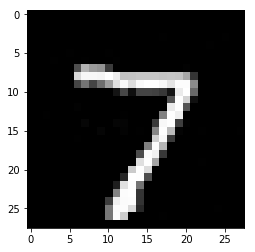

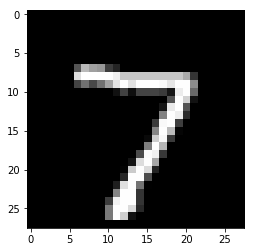

7

In [12]:
i = 0
plt.imshow(x_adv[i].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()
predict(model, x_adv[i])

In [41]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.7619686784297228


In [11]:
adv_path = './tmp/adv/mnist_cnn_hinge_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.99
1.7483367365896703


In [39]:
adv_path = './tmp/adv/mnist_cnn_hinge_10_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.9846761872768401


In [9]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut_w'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
2.0220260658711195


In [13]:
adv_path = './tmp/adv/mnist_cnn_margin_C1_L1'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.257
0.6817249667933211


In [38]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 132us/step


[0.46184693212509154, 0.96]

In [37]:
test_out

{'accuracy': [0.8874,
  0.9267,
  0.9428,
  0.8998,
  0.958,
  0.947,
  0.9274,
  0.9514,
  0.9574,
  0.96,
  0.9482,
  0.9489],
 'loss': [59.199047,
  38.387955,
  30.049332,
  45.49747,
  22.247637,
  25.692705,
  39.69093,
  23.924044,
  21.638086,
  19.400446,
  24.211601,
  23.441643]}